In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3"

OPS_CSV   = f"{DATA_DIR}/operators.csv"
OPE_CSV   = f"{DATA_DIR}/operations.csv"
HRS_CSV   = f"{DATA_DIR}/hours.csv"
TGT_CSV   = f"{DATA_DIR}/target.csv"


In [ ]:
import pandas as pd

operators  = pd.read_csv(OPS_CSV)
operations = pd.read_csv(OPE_CSV)
hours      = pd.read_csv(HRS_CSV)
target     = pd.read_csv(TGT_CSV)

print("operators:")
display(operators.head(10))
print("\n operations:")
display(operations.head())
print("\n hours:", list(hours['hour_id']))
print("\n target:", target.to_dict(orient='records'))


operators:


,operator_id,grade,speed_mult
0,OP01,A,1.10
1,OP02,A,1.10
2,OP03,B,1.00
3,OP04,B,1.00
4,OP05,B,1.00
5,OP06,C,0.95
6,OP07,C,0.95
7,OP08,C,0.95
8,OP09,D,0.90
9,OP10,D,0.90



 operations:


,op_id,operation_name,smv_minutes,min_grade
0,O1,Front panel attach,0.7,C
1,O2,Back panel attach,0.7,C
2,O3,Shoulder join,0.5,B
3,O4,Neck rib attach,0.6,B
4,O5,Sleeve attach L,0.5,B



 hours: ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8']

 target: [{'date': '10/11/2025', 'daily_target_pcs': 288}]


In [ ]:
#Check the entered data are correct
import numpy as np

errors = []

# Grades
valid_grades = set(["A","B","C","D"])
if not operators['grade'].isin(valid_grades).all():
    errors.append("Invalid grade found in operators.csv")

if not operations['min_grade'].isin(valid_grades).all():
    errors.append("Invalid min_grade found in operations.csv")

# SMV positive
if (operations['smv_minutes'] <= 0).any():
    errors.append("Found non-positive SMV(s)")

# speed multipliers in [0.8, 1.2]
if not operators['speed_mult'].between(0.8, 1.2).all():
    errors.append("Found speed_mult outside [0.8,1.2]")

# Uniqueness
if operators['operator_id'].duplicated().any():
    errors.append("Duplicate operator_id")

if operations['op_id'].duplicated().any():
    errors.append("Duplicate op_id")

# Hours count
if len(hours) != 8:
    errors.append("hours.csv should contain exactly 8 rows (H1..H8)")

if errors:
    print("VALIDATION ERRORS:")
    for e in errors:
        print(" -", e)
else:
    print("Validation Passed")


Validation Passed


In [ ]:
#Build grade ordering & eligibility matrix En,o

grade_rank = {"A": 4, "B": 3, "C": 2, "D": 1}

ops = operations.copy()
ops['min_rank'] = ops['min_grade'].map(grade_rank)

ops_map = ops.set_index('op_id')[['operation_name','smv_minutes','min_grade','min_rank']]

opers = operators.copy()
opers['rank'] = opers['grade'].map(grade_rank)

# Cross-join to compute E_{n,o}
opers['_key'] = 1
ops['_key'] = 1
cross = opers.merge(ops[['op_id','min_rank','_key']], on='_key').drop(columns=['_key'])

cross['eligible'] = (cross['rank'] >= cross['min_rank']).astype(int)

# Eligibility matrix (operators x operations)
E = cross.pivot_table(index='operator_id', columns='op_id', values='eligible', aggfunc='max').fillna(0).astype(int)
E.head()


op_id,O1,O10,O11,O12,O13,O14,O2,O3,O4,O5,O6,O7,O8,O9
operator_id,,,,,,,,,,,,,,
OP01,1,1,1,1,1,1,1,1,1,1,1,1,1,1
OP02,1,1,1,1,1,1,1,1,1,1,1,1,1,1
OP03,1,1,1,1,1,1,1,1,1,1,1,1,1,1
OP04,1,1,1,1,1,1,1,1,1,1,1,1,1,1
OP05,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
#Build rate matrix


# R{n,o} = 60 * sn / SMVo
r = opers[['operator_id','speed_mult']].merge(
    operations[['op_id','smv_minutes']], how='cross'
)
r['r_no'] = 60 * r['speed_mult'] / r['smv_minutes']
R = r.pivot_table(index='operator_id', columns='op_id', values='r_no')

# Mask by eligibility (ineligible => 0 rate)
R = R * E
R = R.round(2)
R.head()


op_id,O1,O10,O11,O12,O13,O14,O2,O3,O4,O5,O6,O7,O8,O9
operator_id,,,,,,,,,,,,,,
OP01,94.29,165.0,110.0,36.67,66.0,110.0,94.29,132.0,110.0,132.0,132.0,44.0,165.0,330.0
OP02,94.29,165.0,110.0,36.67,66.0,110.0,94.29,132.0,110.0,132.0,132.0,44.0,165.0,330.0
OP03,85.71,150.0,100.0,33.33,60.0,100.0,85.71,120.0,100.0,120.0,120.0,40.0,150.0,300.0
OP04,85.71,150.0,100.0,33.33,60.0,100.0,85.71,120.0,100.0,120.0,120.0,40.0,150.0,300.0
OP05,85.71,150.0,100.0,33.33,60.0,100.0,85.71,120.0,100.0,120.0,120.0,40.0,150.0,300.0


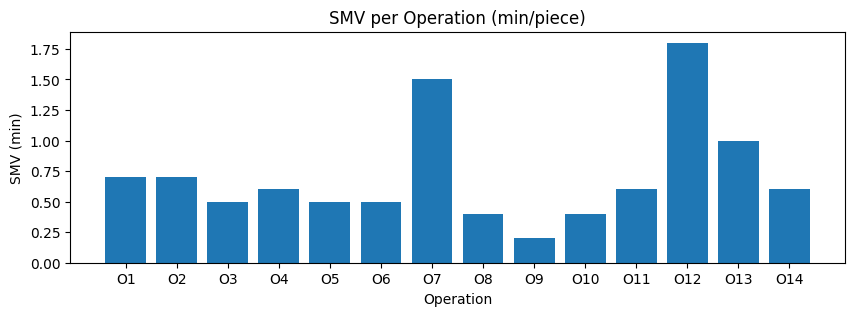

In [ ]:
import matplotlib.pyplot as plt

# 1) SMV bar chart
plt.figure(figsize=(10,3))
plt.bar(operations['op_id'], operations['smv_minutes'])
plt.title("SMV per Operation (min/piece)")
plt.xlabel("Operation")
plt.ylabel("SMV (min)")
plt.show()

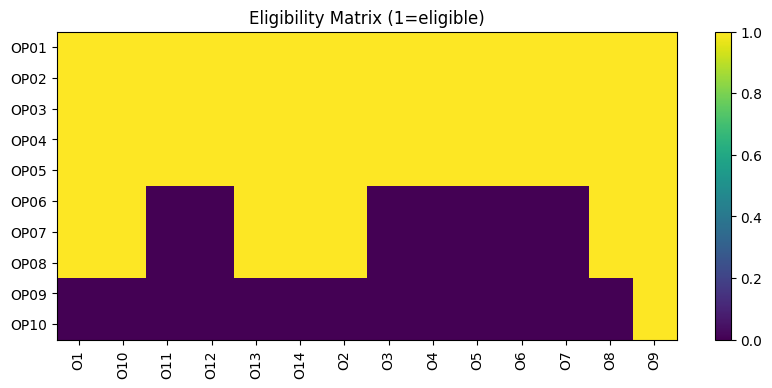

In [ ]:
# 2) Eligibility heatmap (0/1)
plt.figure(figsize=(10,4))
plt.imshow(E.values, aspect='auto')
plt.yticks(range(len(E.index)), E.index)
plt.xticks(range(len(E.columns)), E.columns, rotation=90)
plt.title("Eligibility Matrix (1=eligible)")
plt.colorbar()
plt.show()


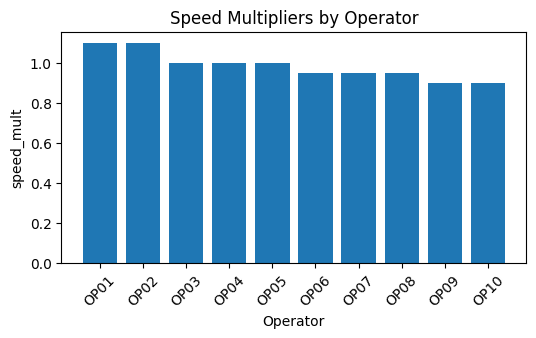

In [ ]:
# 3) Operator speed multipliers
plt.figure(figsize=(6,3))
plt.bar(operators['operator_id'], operators['speed_mult'])
plt.title("Speed Multipliers by Operator")
plt.xlabel("Operator")
plt.ylabel("speed_mult")
plt.xticks(rotation=45)
plt.show()

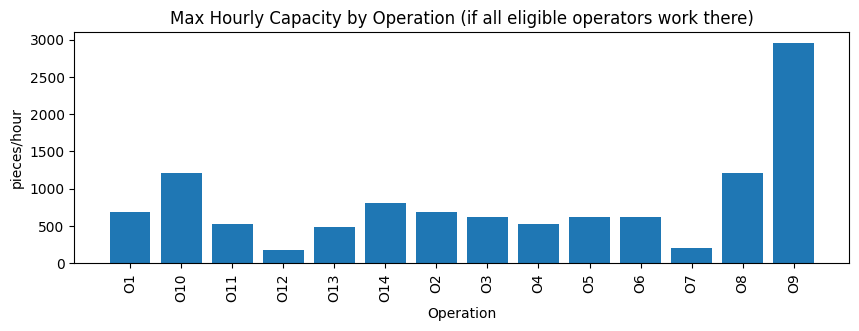

In [ ]:
# 4) Per-operation "max hourly capacity" if all eligible operators work there
max_hourly_by_op = R.sum(axis=0)
plt.figure(figsize=(10,3))
plt.bar(max_hourly_by_op.index, max_hourly_by_op.values)
plt.title("Max Hourly Capacity by Operation (if all eligible operators work there)")
plt.xlabel("Operation")
plt.ylabel("pieces/hour")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 5) Upper bound & takt (print)
S = operations['smv_minutes'].sum()
T_day = len(operators) * 8 * 60  # 4800
UB = T_day / S                   # ~480 pcs/day
takt_320 = (8*60) / target['daily_target_pcs'].iloc[0]  # minutes/piece
print(f"S (sum SMV) = {S:.1f} min/piece")
print(f"Daily operator minutes = {T_day}")
print(f"Theoretical Upper Bound (pcs/day) = {UB:.1f}")
print(f"Takt for target={target['daily_target_pcs'].iloc[0]} pcs: {takt_320:.2f} min/piece")

S (sum SMV) = 10.0 min/piece
Daily operator minutes = 4800
Theoretical Upper Bound (pcs/day) = 480.0
Takt for target=288 pcs: 1.67 min/piece


In [ ]:
#Export processed features for modeling
E_csv = f"{DATA_DIR}/eligibility_matrix.csv"
R_csv = f"{DATA_DIR}/rate_matrix.csv"
CAP_csv = f"{DATA_DIR}/op_max_hourly_capacity.csv"

E.to_csv(E_csv)
R.to_csv(R_csv)
max_hourly_by_op.to_csv(CAP_csv, header=['max_pcs_per_hour'])

print("Saved:")
print("-", E_csv)
print("-", R_csv)
print("-", CAP_csv)

Saved:
- /content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3/eligibility_matrix.csv
- /content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3/rate_matrix.csv
- /content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3/op_max_hourly_capacity.csv


# GA Implementation

In [ ]:
#Load the files from driv( doing this in case if we want to run the GA only with generated file instaed of doing everything from the beginning)
# Load original CSVs (if not already loaded)
import pandas as pd
import numpy as np

operators  = pd.read_csv(OPS_CSV)
operations = pd.read_csv(OPE_CSV)
hours      = pd.read_csv(HRS_CSV)
target     = pd.read_csv(TGT_CSV)

# Load processed matrices you exported in Section 2
E_csv = f"{DATA_DIR}/eligibility_matrix.csv"
R_csv = f"{DATA_DIR}/rate_matrix.csv"

E_df = pd.read_csv(E_csv, index_col=0)
R_df = pd.read_csv(R_csv, index_col=0)

# Keep op_ids and operator_ids for labels/exports later
op_ids = list(R_df.columns)
operator_ids = list(R_df.index)

# Align E/R to operators.csv and operations.csv order (safety)
# (Assumes operators['operator_id'] matches the index names you saved earlier.)
E_df = E_df.reindex(index=operators["operator_id"], columns=operations["op_id"])
R_df = R_df.reindex(index=operators["operator_id"], columns=operations["op_id"])

# To numpy from pandas for the GA core for efficient computation
E = E_df.to_numpy().astype(int)
R = R_df.to_numpy()

# Shapes & helpers 
N, O = E.shape
H = len(hours)
assert R.shape == (N, O), "R shape mismatch vs E"
print("Loaded E and R ✔️  shapes:", E.shape, R.shape)   # E an dR should have the smae shape

# Eligible ops list per operator (used by GA init/mutation)  
eligible_ops_for_n = [np.where(E[n]==1)[0] for n in range(N)]

#list of eligible operations per operator is created from the eligibility matrix which is later 
#used during GA initialization and mutation so that chromosomes are always feasible with respect to skill constraints

# Quick sanity
print("Operators:", list(operators["operator_id"]))
print("Operations (op_ids):", op_ids)
print("Hours:", list(hours["hour_id"]))
print("Target:", int(target["daily_target_pcs"].iloc[0]))


Loaded E and R ✔️  shapes: (10, 14) (10, 14)
Operators: ['OP01', 'OP02', 'OP03', 'OP04', 'OP05', 'OP06', 'OP07', 'OP08', 'OP09', 'OP10']
Operations (op_ids): ['O1', 'O10', 'O11', 'O12', 'O13', 'O14', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9']
Hours: ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8']
Target: 288


In [ ]:
# Bridge (define IDs/names used by GA helpers)
op_ids        = list(operations['op_id'])
op_names      = list(operations['operation_name'])
operator_ids  = list(operators['operator_id'])
hour_ids      = list(hours['hour_id'])
TARGET        = int(target['daily_target_pcs'].iloc[0])

# (Sanity)
assert E.shape == R.shape, "E and R must have same shape"
assert len(op_ids) == E.shape[1] and len(operator_ids) == E.shape[0], "ID alignment mismatch"
print("Ready for GA. N,O,H =", E.shape[0], E.shape[1], len(hour_ids), "Target:", TARGET)

Ready for GA. N,O,H = 10 14 8 Target: 288


In [ ]:
#GA helpers (decode, init, selection, crossover, mutation, intensify)
import random, matplotlib.pyplot as plt
random.seed(42); np.random.seed(42)

# Identify "critical" downstream ops by name (fallback to indices 11/last)
crit_ops = []
for oi, nm in enumerate(op_names):
    if "Final topstitch" in nm or "Final QA" in nm:
        crit_ops.append(oi)
if not crit_ops:
    crit_ops = [min(11, O-1), O-1]
crit_ops = sorted(set([oi for oi in crit_ops if 0 <= oi < O]))

eligible_ops_for_n = [np.where(E[n]==1)[0] for n in range(N)]
O14_idx = O - 1

#  Decoding + fitness (flow throttling enforces precedence)
LAMBDA_FAIR  = 0.2     # small fairness weight
SOFT_TARGET  = True
PENALTY_M    = 10000.0 # big penalty per missing piece

def decode_and_fitness(G):
    # Hourly raw output per op
    y_raw = np.zeros((H,O), dtype=float)
    for h in range(H):
        col = G[:,h]
        for o in range(O):
            mask = (col == o)
            if np.any(mask):
                y_raw[h,o] = R[mask, o].sum()   #raw hourly capacity at operation o

    # Flow throttle: Y[h,o] <= Y[h,o-1]  (precedence enforced here)
    Y = np.zeros((H,O), dtype=float)
    for h in range(H):
        Y[h,0] = y_raw[h,0] + (0 if h==0 else Y[h-1,0])
        for o in range(1,O):
            candidate = (0 if h==0 else Y[h-1,o]) + y_raw[h,o]
            Y[h,o] = min(candidate, Y[h,o-1])   

    final_pieces = Y[-1, O14_idx]
    fairness = float(np.abs(np.full(N,H) - 8).sum())  # 0 in this model
    penalty  = PENALTY_M * max(0.0, TARGET - final_pieces) if SOFT_TARGET else 0.0
    fitness  = final_pieces - LAMBDA_FAIR*fairness - penalty
    return fitness, final_pieces, fairness, y_raw, Y

# GA building blocks: Initialization (roughly follow the natural flow with upstream early op, mild op, downstream later operations(not random chaos))
def init_individual():
    G = np.empty((N,H), dtype=int)
    for n in range(N):
        choices = eligible_ops_for_n[n]
        for h in range(H):
            if h < 3:
                pool = [o for o in choices if o <= min(6, O-1)] or list(choices)       # upstream
            elif h < 5:
                pool = [o for o in choices if 4 <= o <= min(10, O-1)] or list(choices) # mid
            else:
                pool = [o for o in choices if o >= min(9, O-1)] or list(choices)       # downstream
            G[n,h] = np.random.choice(pool)
    return G

def init_population(pop_size):      #Builds an entire population of pop_size individuals.
    return [init_individual() for _ in range(pop_size)]     

def seed_heuristic(forced_O12=2, last_hours=3):     #creates a good initial individual using domain knowledge.
    G = init_individual()

    # find O12 & O14 indices by name (fallbacks)
    idx_O12 = [i for i,nm in enumerate(op_names) if "Final topstitch" in nm]
    idx_O14 = [i for i,nm in enumerate(op_names) if "Final QA" in nm]
    O12i = idx_O12[0] if idx_O12 else min(11, O-1)
    O14i = idx_O14[0] if idx_O14 else O-1

    # force fastest eligible operators on O12 all day
    speed = operators['speed_mult'].to_numpy()
    ranked = np.argsort(-speed)
    placed = 0
    for n in ranked:
        if E[n, O12i] == 1:
            for h in range(H): G[n,h] = O12i
            placed += 1
            if placed >= forced_O12: break

    # ensure at least 1 at O14 for last few hours
    for n in ranked[::-1]:
        if E[n, O14i] == 1:
            for h in range(max(0, H-last_hours), H): G[n,h] = O14i
            break
    return G


#Repair, selection, crossover, mutation


#Repair

#If any gene G[n,h] assigns an ineligible operation: Replace it with the closest eligible operation index.
#This acts as a repair step in case crossover/mutation produce invalid assignments.

def repair_eligibility(G):
    for n in range(N):
        elig = eligible_ops_for_n[n]
        for h in range(H):
            if E[n, G[n,h]] == 0:
                curr = G[n,h]
                G[n,h] = min(elig, key=lambda o: abs(o - curr))
    return G

#Selection
def tournament_select(pop, fitnesses, k):
    idxs = np.random.choice(len(pop), size=k, replace=False)
    return pop[max(idxs, key=lambda i: fitnesses[i])]

#Crossover
def crossover_cols(A, B):
    child = A.copy()
    swap_mask = np.random.rand(H) < 0.5
    for h in range(H):
        if swap_mask[h]: child[:,h] = B[:,h]
    return child

#Local Mutation
def mutate_local(G, mut_rate):
    if np.random.rand() < mut_rate:
        n = np.random.randint(0, N); h = np.random.randint(0, H)
        curr = G[n,h]; elig = eligible_ops_for_n[n]
        dir_down = (h >= 5)
        neighbors = []
        if dir_down and (curr+1) in elig: neighbors.append(curr+1)
        if (not dir_down) and (curr-1) in elig: neighbors.append(curr-1)
        if not neighbors:
            alt = [o for o in elig if o != curr]
            if alt: neighbors = alt
        if neighbors: G[n,h] = random.choice(neighbors)
    return G

#intensification
def intensify(G, tries=12):
    base_fit, base_pcs, *_ = decode_and_fitness(G)
    if base_pcs >= TARGET: return G
    bestG, best_pcs = G, base_pcs
    late_hours = list(range(max(0, H-3), H))
    for _ in range(tries):
        n = np.random.randint(0, N); h = random.choice(late_hours)
        cand_ops = [o for o in crit_ops if E[n,o]==1]
        if not cand_ops: continue
        old = G[n,h]; new = random.choice(cand_ops)
        if new == old: continue
        G[n,h] = new
        _, pcs, *_ = decode_and_fitness(G)
        if pcs > best_pcs:
            bestG, best_pcs = G.copy(), pcs
        else:
            G[n,h] = old
    return bestG

In [ ]:
#hyperparameter tuning sweep
def run_ga_once(pop_size, mut_rate, gens=120, seed=42):
    random.seed(seed); np.random.seed(seed)
    ELITE, TOUR_K = 5, 3
    pop = init_population(pop_size)
    for _ in range(gens):
        fits = [decode_and_fitness(ind)[0] for ind in pop]
        elite_idx = np.argsort(fits)[-ELITE:]
        nxt = [pop[i].copy() for i in elite_idx]
        while len(nxt) < pop_size:
            p1 = tournament_select(pop, fits, TOUR_K)
            p2 = tournament_select(pop, fits, TOUR_K)
            child = crossover_cols(p1, p2)
            child = mutate_local(child, mut_rate)
            child = repair_eligibility(child)
            nxt.append(child)
        pop = nxt
    fits = [decode_and_fitness(ind)[0] for ind in pop]
    idx = int(np.argmax(fits))
    f, pcs, fair, *_ = decode_and_fitness(pop[idx])
    return f, pcs, fair

grid = []
for ps in [60, 80, 100]:
    for mr in [0.05, 0.10, 0.15]:
        f, pcs, fair = run_ga_once(ps, mr, gens=120, seed=42)
        grid.append({"pop": ps, "mut": mr, "fitness": f, "pieces": pcs, "fairness": fair})
df = pd.DataFrame(grid).sort_values(by=["pieces","fitness","fairness"], ascending=[False,False,True]).reset_index(drop=True)
display(df.head(10))

# Choose the best from the sweep for your final GA run:
best_pop = int(df.loc[0,"pop"])
best_mut = float(df.loc[0,"mut"])
print(f"Selected from sweep → POP_SIZE={best_pop}, MUT_RATE={best_mut}")

KeyboardInterrupt: 

In [ ]:
#Final GA run (target-aware, seeded, intensification)
POP_SIZE     = best_pop if 'best_pop' in globals() else 80
MUT_RATE     = best_mut if 'best_mut' in globals() else 0.15
GENERATIONS  = 300
ELITE        = max(5, POP_SIZE//12)
TOUR_K       = 4 if POP_SIZE >= 100 else 3

# Init population + seeds
population = init_population(POP_SIZE)
population[0] = seed_heuristic(forced_O12=3, last_hours=4)
population[1] = seed_heuristic(forced_O12=2, last_hours=5)

best_hist, mean_hist = [], []

for gen in range(GENERATIONS):
    fits = [decode_and_fitness(ind)[0] for ind in population]
    best_hist.append(float(np.max(fits))); mean_hist.append(float(np.mean(fits)))

    elite_idx = np.argsort(fits)[-ELITE:]
    next_pop = [population[i].copy() for i in elite_idx]

    while len(next_pop) < POP_SIZE:
        p1 = tournament_select(population, fits, TOUR_K)
        p2 = tournament_select(population, fits, TOUR_K)
        child = crossover_cols(p1, p2)
        child = mutate_local(child, MUT_RATE)
        child = repair_eligibility(child)
        if gen > GENERATIONS // 3 and (len(next_pop) % 4 == 0):
            child = intensify(child, tries=8 if gen < (2*GENERATIONS)//3 else 14)
        next_pop.append(child)

    population = next_pop

# Final best + intensify
final_fits = [decode_and_fitness(ind)[0] for ind in population]
best_idx = int(np.argmax(final_fits))
best_ind = population[best_idx]
best_ind = intensify(best_ind, tries=20)

best_fit, best_pcs, best_fair, best_yraw, best_Y = decode_and_fitness(best_ind)
print(f"Best fitness: {best_fit:.2f}")
print(f"Finished pieces at O14: {best_pcs:.1f}")
print(f"Fairness (Σ|w-8|): {best_fair:.1f}")

# Hourly O14 output for plots/exports
y14 = np.diff(np.concatenate([[0.0], best_Y[:, -1]]))

Best fitness: 300.00
Finished pieces at O14: 300.0
Fairness (Σ|w-8|): 0.0


In [ ]:
#final check
import numpy as np

def check_constraints(G, E, R, hours, target_val):
    N, H = G.shape
    O = R.shape[1]
    ok = True
    msgs = []

    # (1) One operation per operator per hour – by construction G has exactly one op per hour, so OK.

    # (2) Eligibility: E[n, op] must be 1 for all assignments
    bad = []
    for n in range(N):
        for h in range(H):
            o = G[n,h]
            if E[n, o] != 1:
                bad.append((n,h,o))
    if bad:
        ok = False
        msgs.append(f"Eligibility violations: {len(bad)} (first few: {bad[:5]})")
    else:
        msgs.append("Eligibility: OK")

    # (3) Precedence/flow: cumulative Y[h,o] <= Y[h,o-1]
    # Recompute y_raw and Y exactly as in decode
    O14_idx = O - 1
    y_raw = np.zeros((H,O), dtype=float)
    for h in range(H):
        for o in range(O):
            mask = (G[:,h] == o)
            if np.any(mask):
                y_raw[h,o] = R[mask, o].sum()

    Y = np.zeros((H,O), dtype=float)
    for h in range(H):
        if h == 0:
            Y[h,0] = y_raw[h,0]
        else:
            Y[h,0] = Y[h-1,0] + y_raw[h,0]
        for o in range(1,O):
            candidate = (0 if h==0 else Y[h-1,o]) + y_raw[h,o]
            left = Y[h,o-1]
            Y[h,o] = min(candidate, left)

    # Check monotonicity w.r.t upstream at each hour
    flow_viol = []
    for h in range(H):
        for o in range(1,O):
            if Y[h,o] > Y[h,o-1] + 1e-6:
                flow_viol.append((h,o,Y[h,o],Y[h,o-1]))
    if flow_viol:
        ok = False
        msgs.append(f"Flow violations: {len(flow_viol)}")
    else:
        msgs.append("Precedence/flow: OK")

    # (4) Demand (if treating as hard requirement)
    final_pcs = Y[-1, O14_idx]
    if final_pcs + 1e-6 >= target_val:
        msgs.append(f"Demand: OK (O14 = {final_pcs:.2f} ≥ {target_val})")
    else:
        msgs.append(f"Demand: NOT MET (O14 = {final_pcs:.2f} < {target_val})")
        ok = False

    return ok, msgs, final_pcs, Y, y_raw

target_val = int(target["daily_target_pcs"].iloc[0])
ok, msgs, final_pcs, Y_best, yraw_best = check_constraints(best_ind, E, R, hours, target_val)

print("Constraint check:", "PASS ✅" if ok else "FAIL ❌")
for m in msgs:
    print("-", m)

# Report GA objective explicitly (matches your fitness definition without the penalty term)
LAMBDA_FAIR = 0.2  # keep consistent with your GA
w = np.full(E.shape[0], len(hours))  # everyone works 8h -> fairness deviation = 0 here
fairness = np.abs(w - 8).sum()
ga_objective = final_pcs - LAMBDA_FAIR * fairness
print(f"GA Objective (pieces − λ·fairness): {ga_objective:.2f}")
print(f"Finished pieces at O14: {final_pcs:.2f}")


Constraint check: PASS ✅
- Eligibility: OK
- Precedence/flow: OK
- Demand: OK (O14 = 300.00 ≥ 288)
GA Objective (pieces − λ·fairness): 300.00
Finished pieces at O14: 300.00


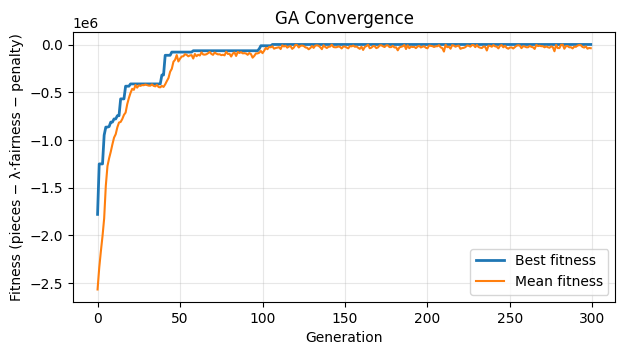

In [ ]:
# Convergence
plt.figure(figsize=(7,3.5))
plt.plot(best_hist, label="Best fitness", linewidth=2)
plt.plot(mean_hist, label="Mean fitness", linewidth=1.5)
plt.xlabel("Generation"); plt.ylabel("Fitness (pieces − λ·fairness − penalty)")
plt.title("GA Convergence"); plt.grid(True, alpha=0.3); plt.legend(); plt.show()



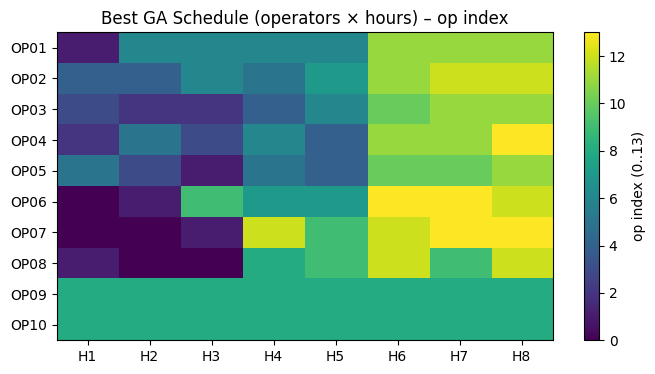

In [ ]:
# Schedule heatmap (op index)
plt.figure(figsize=(8,4))
plt.imshow(best_ind, aspect='auto')
plt.title("Best GA Schedule (operators × hours) – op index")
plt.yticks(range(N), operator_ids)
plt.xticks(range(H), hour_ids)
plt.colorbar(label=f"op index (0..{O-1})")
plt.show()

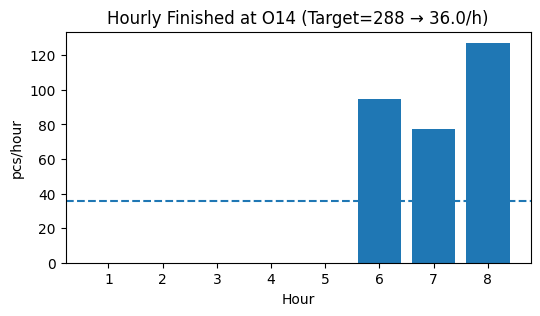

In [ ]:
# Hourly O14 bar with takt
takt_per_hour = TARGET / H
plt.figure(figsize=(6,3))
plt.bar(range(1,H+1), y14)
plt.axhline(takt_per_hour, linestyle="--")
plt.title(f"Hourly Finished at O14 (Target={TARGET} → {takt_per_hour:.1f}/h)")
plt.xlabel("Hour"); plt.ylabel("pcs/hour")
plt.show()

In [ ]:
# Demand check
print(f"Demand check: {'OK ✅' if best_pcs + 1e-6 >= TARGET else 'NOT MET ❌'} (O14={best_pcs:.1f} vs {TARGET})")

Demand check: OK ✅ (O14=300.0 vs 288)


In [ ]:
# 1) Export schedule with op_ids
best_op_ids = np.vectorize(lambda o: op_ids[o])(best_ind)
sched_df = pd.DataFrame(best_op_ids, columns=hour_ids)
sched_df.insert(0, "operator_id", operator_ids)

out_sched = f"{DATA_DIR}/GA_best_schedule.csv"
out_kpis  = f"{DATA_DIR}/GA_kpis.txt"
sched_df.to_csv(out_sched, index=False)

with open(out_kpis, "w") as f:
    f.write(f"Best fitness: {best_fit:.2f}\n")
    f.write(f"Finished pieces at O14: {best_pcs:.1f}\n")
    f.write(f"Fairness (Σ|w-8|): {best_fair:.1f}\n")
    f.write("Hourly finished pieces at O14: " + ", ".join([f"{v:.1f}" for v in y14]) + "\n")

print("Saved:")
print(out_sched)
print(out_kpis)


Saved:
/content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3/GA_best_schedule.csv
/content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3/GA_kpis.txt


In [ ]:
# 2) Nice inspection tables
# a) op names per cell
sched_names = np.vectorize(lambda o: op_names[o])(best_ind)
sched_names_df = pd.DataFrame(sched_names, index=operator_ids, columns=hour_ids)

# b) staffing counts by op & hour
staff_counts = np.zeros((O,H), dtype=int)
for h in range(H):
    for o in range(O):
        staff_counts[o,h] = int(np.sum(best_ind[:,h] == o))
staff_counts_df = pd.DataFrame(staff_counts, index=op_ids, columns=hour_ids)

# c) hourly pieces by op (y_raw)
y_raw_df = pd.DataFrame(best_yraw, index=hour_ids, columns=op_ids)

# d) hourly O14 pieces
y14_df = pd.DataFrame({"pcs_at_O14_this_hour": y14}, index=hour_ids)

# display
print("\n=== Schedule (operation_name) ===")
display(sched_names_df)
print("\n=== Staffing counts (operators per op per hour) ===")
display(staff_counts_df)
print("\n=== Hourly pieces by operation (y_raw) ===")
display(y_raw_df.round(2))
print("\n=== Hourly finished at O14 ===")
display(y14_df.round(2))


=== Schedule (operation_name) ===


,H1,H2,H3,H4,H5,H6,H7,H8
OP01,Back panel attach,Side seam close,Side seam close,Side seam close,Side seam close,Final topstitch,Final topstitch,Final topstitch
OP02,Sleeve attach L,Sleeve attach L,Side seam close,Sleeve attach R,Bottom hem,Final topstitch,Pressing,Pressing
OP03,Neck rib attach,Shoulder join,Shoulder join,Sleeve attach L,Side seam close,Buttonhole,Final topstitch,Final topstitch
OP04,Shoulder join,Sleeve attach R,Neck rib attach,Side seam close,Sleeve attach L,Final topstitch,Final topstitch,Final QA
OP05,Sleeve attach R,Neck rib attach,Back panel attach,Sleeve attach R,Sleeve attach L,Buttonhole,Buttonhole,Final topstitch
OP06,Front panel attach,Back panel attach,Button attach,Bottom hem,Bottom hem,Final QA,Final QA,Pressing
OP07,Front panel attach,Front panel attach,Back panel attach,Pressing,Button attach,Pressing,Final QA,Final QA
OP08,Back panel attach,Front panel attach,Front panel attach,Label attach,Button attach,Pressing,Button attach,Pressing
OP09,Label attach,Label attach,Label attach,Label attach,Label attach,Label attach,Label attach,Label attach
OP10,Label attach,Label attach,Label attach,Label attach,Label attach,Label attach,Label attach,Label attach



=== Staffing counts (operators per op per hour) ===


,H1,H2,H3,H4,H5,H6,H7,H8
O1,2,2,1,0,0,0,0,0
O2,2,1,2,0,0,0,0,0
O3,1,1,1,0,0,0,0,0
O4,1,1,1,0,0,0,0,0
O5,1,1,0,1,2,0,0,0
O6,1,1,0,2,0,0,0,0
O7,0,1,2,2,2,0,0,0
O8,0,0,0,1,2,0,0,0
O9,2,2,2,3,2,2,2,2
O10,0,0,1,0,2,0,1,0



=== Hourly pieces by operation (y_raw) ===


,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10,O11,O12,O13,O14
H1,162.86,175.72,120.0,100.0,132.0,120.0,0.0,0.0,540.0,0.0,0.0,0.00,0.0,0.0
H2,162.86,81.43,120.0,100.0,132.0,120.0,44.0,0.0,540.0,0.0,0.0,0.00,0.0,0.0
H3,81.43,167.14,120.0,100.0,0.0,0.0,88.0,0.0,540.0,142.5,0.0,0.00,0.0,0.0
H4,0.00,0.00,0.0,0.0,120.0,252.0,84.0,142.5,825.0,0.0,0.0,0.00,57.0,0.0
H5,0.00,0.00,0.0,0.0,240.0,0.0,84.0,307.5,540.0,285.0,0.0,0.00,0.0,0.0
H6,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,540.0,0.0,200.0,106.67,114.0,95.0
H7,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,540.0,142.5,100.0,103.33,66.0,190.0
H8,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,540.0,0.0,0.0,103.33,180.0,195.0



=== Hourly finished at O14 ===


,pcs_at_O14_this_hour
H1,0.00
H2,0.00
H3,0.00
H4,0.00
H5,0.00
H6,95.00
H7,77.67
H8,127.33


In [ ]:
# save
sched_names_df.to_csv(f"{DATA_DIR}/GA_best_schedule_names.csv")
staff_counts_df.to_csv(f"{DATA_DIR}/GA_staffing_counts.csv")
y_raw_df.to_csv(f"{DATA_DIR}/GA_yraw_by_op_hour.csv")
y14_df.to_csv(f"{DATA_DIR}/GA_O14_hourly.csv")
print("\nAlso saved the inspection tables to your DATA_DIR.")


Also saved the inspection tables to your DATA_DIR.


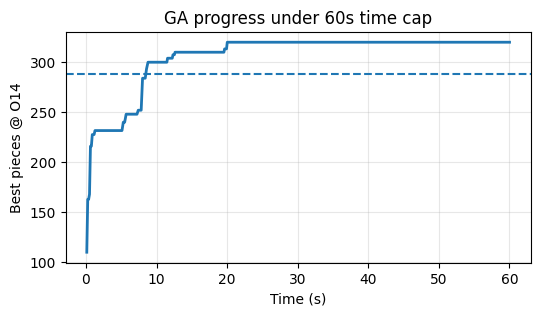

In [ ]:
# Optional: progress plot vs time
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.plot(time_hist, best_pieces_hist, linewidth=2)
plt.axhline(TARGET, linestyle="--")
plt.xlabel("Time (s)"); plt.ylabel("Best pieces @ O14")
plt.title("GA progress under 60s time cap"); plt.grid(True, alpha=0.3); plt.show()

# Mixed-Integer Programming (MIP)

In [ ]:
!pip -q install pulp

In [ ]:
#load the necessary files

import pandas as pd, numpy as np
from pathlib import Path

operators  = pd.read_csv(OPS_CSV)
operations = pd.read_csv(OPE_CSV)
hours      = pd.read_csv(HRS_CSV)
target     = pd.read_csv(TGT_CSV)

grade_rank = {"A":4,"B":3,"C":2,"D":1}

# Try to load preprocessed E/R; else rebuild
E_path = Path(f"{DATA_DIR}/eligibility_matrix.csv")
R_path = Path(f"{DATA_DIR}/rate_matrix.csv")

if E_path.exists() and R_path.exists():
    E_df = pd.read_csv(E_path, index_col=0)
    R_df = pd.read_csv(R_path, index_col=0)
    # Align to current order
    E_df = E_df.reindex(index=operators["operator_id"], columns=operations["op_id"])
    R_df = R_df.reindex(index=operators["operator_id"], columns=operations["op_id"])
else:
    ops = operations.copy(); ops["min_rank"] = ops["min_grade"].map(grade_rank)
    opers = operators.copy(); opers["rank"] = opers["grade"].map(grade_rank)
    E = (opers["rank"].to_numpy()[:,None] >= ops["min_rank"].to_numpy()[None,:]).astype(int)
    E_df = pd.DataFrame(E, index=operators["operator_id"], columns=operations["op_id"])
    R = (60.0*operators["speed_mult"].to_numpy()[:,None] / operations["smv_minutes"].to_numpy()[None,:]) * E
    R_df = pd.DataFrame(np.round(R,2), index=operators["operator_id"], columns=operations["op_id"])

# Basic sets/ids
N = len(operators); O = len(operations); H = len(hours)
operator_ids = list(operators["operator_id"])
op_ids       = list(operations["op_id"])
hour_ids     = list(hours["hour_id"])
TARGET       = int(target["daily_target_pcs"].iloc[0])

print("E shape:", E_df.shape, "R shape:", R_df.shape, "N,O,H:", N,O,H, "Target:", TARGET)

E shape: (10, 14) R shape: (10, 14) N,O,H: 10 14 8 Target: 288


In [ ]:
import pulp
print("PuLP version:", pulp.__version__)

PuLP version: 3.3.0


In [ ]:
#  Build & solve MILP with CBC (<=1 assignment)
import pulp as pl, time
from pathlib import Path
import pandas as pd

operator_ids = list(operators["operator_id"])
op_ids       = list(operations["op_id"])
hour_ids     = list(hours["hour_id"])
TARGET       = int(target["daily_target_pcs"].iloc[0])
final_op     = op_ids[-1]

# Dicts
E = {(n,o): int(E_df.loc[n,o]) for n in operator_ids for o in op_ids}
R = {(n,o): float(R_df.loc[n,o]) for n in operator_ids for o in op_ids}

# Model
model = pl.LpProblem("Sewing_DayPlan_MILP", pl.LpMaximize)

# Vars
x = pl.LpVariable.dicts("x", (operator_ids, hour_ids, op_ids), 0, 1, cat=pl.LpBinary)
y = pl.LpVariable.dicts("y", (hour_ids, op_ids), lowBound=0, cat=pl.LpContinuous)
Y = pl.LpVariable.dicts("Y", (hour_ids, op_ids), lowBound=0, cat=pl.LpContinuous)

# (1) One operation per operator-hour (allow idle if needed)
for n in operator_ids:
    for h in hour_ids:
        model += pl.lpSum(x[n][h][o] for o in op_ids) <= 1, f"assign_le1_{n}_{h}"

# (2) Eligibility
for n in operator_ids:
    for h in hour_ids:
        for o in op_ids:
            model += x[n][h][o] <= E[(n,o)], f"elig_{n}_{h}_{o}"

# (3) y definition
for h in hour_ids:
    for o in op_ids:
        model += y[h][o] == pl.lpSum(R[(n,o)] * x[n][h][o] for n in operator_ids), f"def_y_{h}_{o}"

# (4) Cumulative flow + precedence
for hi, h in enumerate(hour_ids):
    for oi, o in enumerate(op_ids):
        if hi == 0:
            model += Y[h][o] == y[h][o], f"cum0_{h}_{o}"
        else:
            hprev = hour_ids[hi-1]
            model += Y[h][o] == Y[hprev][o] + y[h][o], f"cum_{h}_{o}"
        if oi > 0:
            o_prev = op_ids[oi-1]
            model += Y[h][o] <= Y[h][o_prev], f"flow_{h}_{o}"

# (5) Demand
model += pl.lpSum(y[h][final_op] for h in hour_ids) >= TARGET, "demand_final"

# Objective: maximize throughput
model += pl.lpSum(y[h][final_op] for h in hour_ids)

# Warm-start from GA (optional)
warm = Path(f"{DATA_DIR}/GA_best_schedule.csv")
if warm.exists():
    try:
        ga = pd.read_csv(warm).set_index("operator_id").reindex(operator_ids)
        for n in operator_ids:
            for h in hour_ids:
                if h in ga.columns:
                    o_star = ga.loc[n, h]
                    for o in op_ids:
                        x[n][h][o].setInitialValue(1 if o == o_star else 0)
    except Exception as e:
        print("Warm-start skipped:", e)

# CBC with time limit (gap optional)
TIME_LIMIT = 60
solver = pl.PULP_CBC_CMD(msg=False, timeLimit=TIME_LIMIT)  # PuLP 3.3.0: gapRel optional

t0 = time.time()
status = model.solve(solver)
t1 = time.time()

print("Status:", pl.LpStatus[status])
print("Solve time (s):", round(t1 - t0, 3))
print("Objective:", round(pl.value(model.objective), 2))

final_pcs = sum(y[h][final_op].value() for h in hour_ids)
print(f"Finished pieces at final stage: {final_pcs:.2f}")

Status: Not Solved
Solve time (s): 59.998
Objective: 394.29
Finished pieces at final stage: 394.29


In [ ]:
# Export MIP schedule & KPIs
import pandas as pd
from pathlib import Path

operator_ids = list(operators["operator_id"])
hour_ids     = list(hours["hour_id"])
op_ids       = list(operations["op_id"])

# 1) Build a readable schedule table (operators × hours with op_id)
assign = []
for n in operator_ids:
    row = {"operator_id": n}
    for h in hour_ids:
        # pick the op with the largest x value (handle numerical tolerances)
        vals = [(o, x[n][h][o].value() or 0.0) for o in op_ids]
        o_star = max(vals, key=lambda t: t[1])[0]
        row[h] = o_star
    assign.append(row)

sched_mip = pd.DataFrame(assign)

# 2) Save CSVs
mip_sched_csv = f"{DATA_DIR}/MIP_best_schedule.csv"
mip_kpi_txt   = f"{DATA_DIR}/MIP_kpis.txt"

sched_mip.to_csv(mip_sched_csv, index=False)

final_op   = op_ids[-1]
final_pcs  = sum((y[h][final_op].value() or 0.0) for h in hour_ids)
mip_obj    = pl.value(model.objective)
mip_status = pl.LpStatus[status]

with open(mip_kpi_txt, "w") as f:
    f.write(f"Status: {mip_status}\n")
    f.write(f"Solve time (s): {round(t1 - t0, 3)}\n")
    f.write(f"Objective: {mip_obj:.2f}\n")
    f.write(f"Finished pieces at final: {final_pcs:.2f}\n")

print("Saved:")
print(mip_sched_csv)
print(mip_kpi_txt)

Saved:
/content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3/MIP_best_schedule.csv
/content/drive/MyDrive/Colab Notebooks/ML_CW_010/ML_CW_Q3/MIP_kpis.txt


In [ ]:
print("Zero-eligibility operators:",
      list(E_df.index[E_df.sum(axis=1)==0]))
print("Zero-eligibility operations:",
      list(E_df.columns[E_df.sum(axis=0)==0]))

Zero-eligibility operators: []
Zero-eligibility operations: []


/tmp/ipython-input-2666909328.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  G_idx = mip_sched.applymap(lambda v: op_id_to_idx.get(v, np.nan)).to_numpy()


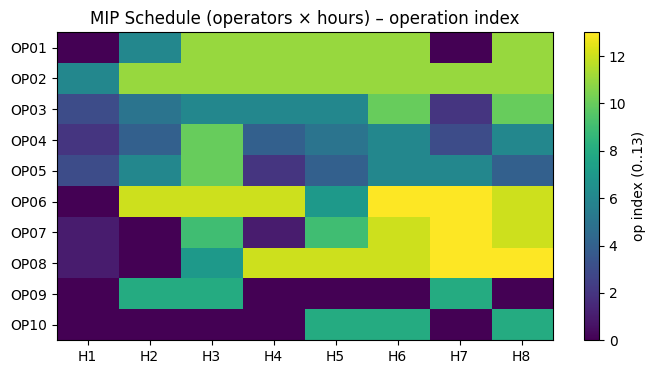

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# Load schedule (try IDs first, else names)
try:
    mip_sched = pd.read_csv(f"{DATA_DIR}/MIP_best_schedule.csv").set_index("operator_id")
except Exception:
    mip_sched = pd.read_csv(f"{DATA_DIR}/MIP_best_schedule_names.csv").set_index("operator_id")

# Ensure row/column order matches your operators/hours used elsewhere
mip_sched = mip_sched.reindex(index=operators["operator_id"], columns=hours["hour_id"])

# Build mapping: op_id -> numeric index (0..O-1)
op_ids = list(operations["op_id"])
op_id_to_idx = {op_id: i for i, op_id in enumerate(op_ids)}

# If the schedule contains operation NAMES, map names -> ids first
if not set(np.ravel(mip_sched.values)).issubset(set(op_ids)):
    name_to_id = dict(zip(operations["operation_name"], operations["op_id"]))
    mip_sched = mip_sched.applymap(lambda v: name_to_id.get(v, v))

# Now map op_id strings to integer indices
G_idx = mip_sched.applymap(lambda v: op_id_to_idx.get(v, np.nan)).to_numpy()

# Safety check
if np.isnan(G_idx).any():
    bad = np.argwhere(np.isnan(G_idx))
    raise ValueError(f"Unmapped op_id(s) in schedule at positions (row,col): {bad[:5]}")

plt.figure(figsize=(8,4))
plt.imshow(G_idx.astype(int), aspect='auto')
plt.title("MIP Schedule (operators × hours) – operation index")
plt.yticks(range(len(mip_sched.index)), mip_sched.index)
plt.xticks(range(len(mip_sched.columns)), mip_sched.columns)
cbar = plt.colorbar()
cbar.set_label(f"op index (0..{len(op_ids)-1})")
plt.show()

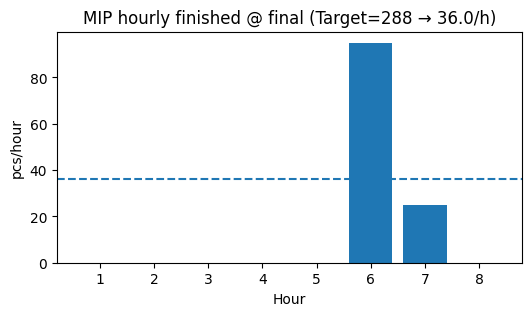

Total finished pieces at final = 120.00


In [ ]:
# We assume R_df/E_df already loaded & aligned; if not, rebuild as earlier.
# Align R to the same operator & op order
R_df_aligned = R_df.reindex(index=operators["operator_id"], columns=operations["op_id"])

R = R_df_aligned.to_numpy()
N = len(operators); H = len(hours); O = len(operations)

# Use the numeric grid from above (G_idx: N x H with op indices)
# Compute y_raw[h,o] = sum over n assigned to o at hour h of R[n,o]
y_raw = np.zeros((H, O), dtype=float)
for h in range(H):
    for o in range(O):
        mask = (G_idx[:, h] == o)
        if np.any(mask):
            y_raw[h, o] = R[mask, o].sum()

# Flow-throttled cumulative Y (same as GA decode)
Y = np.zeros((H, O), dtype=float)
for h in range(H):
    Y[h, 0] = y_raw[h, 0] + (0 if h == 0 else Y[h-1, 0])
    for o in range(1, O):
        cand = (0 if h == 0 else Y[h-1, o]) + y_raw[h, o]
        Y[h, o] = min(cand, Y[h, o-1])

# Hourly finished at final stage
y_final_hourly = np.diff(np.concatenate([[0.0], Y[:, -1]]))
takt = int(target["daily_target_pcs"].iloc[0]) / H

import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.bar(range(1, H+1), y_final_hourly)
plt.axhline(takt, linestyle="--")
plt.title(f"MIP hourly finished @ final (Target={int(target['daily_target_pcs'].iloc[0])} → {takt:.1f}/h)")
plt.xlabel("Hour"); plt.ylabel("pcs/hour")
plt.show()

print(f"Total finished pieces at final = {Y[-1, -1]:.2f}")

explanation about above graph:  The CBC solver hit the 60-second time limit (status ‘Not Solved’), so the printed objective 394.29 corresponds to the best solution the solver found, which may still contain fractional assignments. When I reconstruct a practical integer schedule by rounding the x-values and then simulate the actual flow with precedence, the achievable output at the final operation is lower (120) than this number. This shows that under the time cap, the MILP did not fully converge to a high-quality, implementable integer schedule, whereas the GA produced a consistent integer schedule whose simulated flow directly matches its final pieces.

Compare the GA and MILP interms of solution quality, computational time, and scalability. MILP has a timelimit of 60S. So GA set to 60S and ran again in order to ge apple to apple comparison

In [ ]:
# Time-capped GA run (60s) To compare the computational timing with MILP
import time, numpy as np, random
random.seed(42); np.random.seed(42)

# Keep the same tuned settings
POP_SIZE    = 80
MUT_RATE    = 0.15
GENERATIONS = 10000  # very high; time cap will stop early
ELITE       = max(5, POP_SIZE // 12)
TOUR_K      = 4

TIME_LIMIT_S = 60.0

# Optional: assert GA fitness settings
print("SOFT_TARGET set to:", SOFT_TARGET, "| PENALTY_M:", PENALTY_M, "| TARGET:", TARGET)

population = init_population(POP_SIZE)
# heuristic seeds
population[0] = seed_heuristic(forced_O12=3, last_hours=4)
population[1] = seed_heuristic(forced_O12=2, last_hours=5)

best_hist, time_hist, best_pieces_hist = [], [], []

t0 = time.time()
gen = 0
while gen < GENERATIONS:
    # fitness & pieces for current population
    vals = [decode_and_fitness(ind) for ind in population]
    fits  = [v[0] for v in vals]
    pcses = [v[1] for v in vals]
    best_hist.append(float(np.max(fits)))
    best_pieces_hist.append(float(np.max(pcses)))
    time_hist.append(time.time() - t0)

    # stop if time cap hit
    if time_hist[-1] >= TIME_LIMIT_S:
        break

    # elites
    elite_idx = np.argsort(fits)[-ELITE:]
    next_pop = [population[i].copy() for i in elite_idx]

    # reproduce
    while len(next_pop) < POP_SIZE:
        p1 = tournament_select(population, fits, TOUR_K)
        p2 = tournament_select(population, fits, TOUR_K)
        child = crossover_cols(p1, p2)
        child = mutate_local(child, MUT_RATE)
        child = repair_eligibility(child)
        # late intensification
        if gen > 50 and (len(next_pop) % 4 == 0):
            child = intensify(child, tries=12)
        next_pop.append(child)

    population = next_pop
    gen += 1

# finalize best
final_vals = [decode_and_fitness(ind) for ind in population]
final_fits  = [v[0] for v in final_vals]
final_pcses = [v[1] for v in final_vals]
best_idx = int(np.argmax(final_fits))
best_ind = population[best_idx]
best_ind = intensify(best_ind, tries=30)
best_fit, best_pcs, best_fair, best_yraw, best_Y = decode_and_fitness(best_ind)

ga_time_s = time.time() - t0
print(f"[GA 60s cap] pieces: {best_pcs:.2f} | time: {ga_time_s:.2f}s | gens done: {gen}")

SOFT_TARGET set to: True | PENALTY_M: 10000.0 | TARGET: 288
[GA 60s cap] pieces: 320.00 | time: 60.09s | gens done: 511


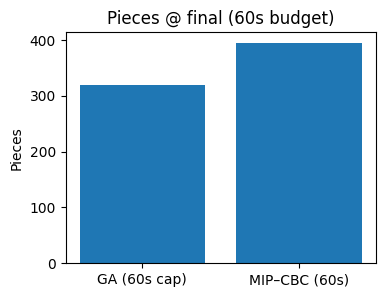

In [ ]:
import pandas as pd, matplotlib.pyplot as plt
comp = pd.DataFrame([
    {"method":"GA (60s cap)",   "pieces": 320.00,   "time_s": 60.1},
    {"method":"MIP–CBC (60s)",  "pieces": 394.29,   "time_s": 59.98},
])

plt.figure(figsize=(4,3)); plt.bar(comp["method"], comp["pieces"]);
plt.ylabel("Pieces"); plt.title("Pieces @ final (60s budget)"); plt.show()